Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [3]:
# import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import category_encoders as ce

In [4]:
# train validation split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
# Cleaning/engineering function
def wrangler(X):
    
    # Make a copy to avoid warning, prevent making changes from view.
    X = X.copy()
    
    # Replace near-zero latitudes with zero
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Replace near-zero longitudes with zero
    X['longitude'] = X['longitude'].replace(-2e-08, 0)
    
    # Swap zeros with nulls
    cols_with_zeros = ['longitude', 'latitude','construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # All the following are duplicate drops
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # extraction_type is a more specific version of extraction_type_group/class
    X = X.drop(columns=['extraction_type_group','extraction_type_class'])
    
    # Same for management and management_group
    X = X.drop(columns = 'management_group')
    
    # And payment / payment_type
    X = X.drop(columns = 'payment')
    
    # And water_quality/quality_group
    X = X.drop(columns = 'quality_group')
    
    # And water_quality/quality_group
    X = X.drop(columns = 'waterpoint_type_group')
    
    # Feature creation
    # create a 'distance from Dodoma' feature
    X['dodomadistance'] = (((X['latitude']-(6.1630))**2)+((X['longitude']-(35.7516))**2))**0.5
    
    # create a pump age feature
    X['pump_age'] = 2013 - X['construction_year']
    
    # create 'year_recorded' - year from date_recorded
    X['year_recorded'] = pd.to_datetime(X.date_recorded).dt.year
    
    # create 'structspect_interval' - number of years between construction and date recorded
    X['structspect_interval'] = X['year_recorded'] - X['construction_year']
    
    # return the wrangled dataframe
    return X

In [6]:
# Clean and engineer all datasets
train = wrangler(train)
val = wrangler(val)
test = wrangler(test)

In [7]:
# Define target
target = 'status_group'

# Frame without target and id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the number of unique classes for each categorical variable
catswithcounts = train_features.select_dtypes(exclude='number').nunique()

# set upper bound on class count
categorical_features = catswithcounts[catswithcounts <= 100].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange train/val/test data
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [8]:
# Mapped version of targets for some encoders
mapdict = {
    'functional': 1,
    'non functional': -1,
    'functional needs repair': 0
}
y_train_mapped = y_train.map(mapdict)
y_val_mapped = y_val.map(mapdict)

In [9]:
# Make random forest pipeline

thelorax = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=16, random_state=42, n_jobs = -1)
)

In [10]:
# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.9878998316498316
validation accuracy:  0.7978114478114479


In [11]:
# Bump the number of estimators, use ordinal encoding

thelorax = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=256, random_state=42, n_jobs = -1)
)

In [12]:
# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.9959595959595959
validation accuracy:  0.8026936026936027


In [13]:
# Use hyperparameters from last assignment

thelorax = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=256, max_depth=28, min_samples_leaf=17, random_state=42, n_jobs = -1)
)

In [14]:
# fit it and score it
thelorax.fit(X_train,y_train)
print ('train accuracy: ', thelorax.score(X_train, y_train))
print ('validation accuracy: ', thelorax.score(X_val, y_val))

train accuracy:  0.8100799663299664
validation accuracy:  0.7859427609427609


In [15]:
# Tune hyperparameters
# Grab my gradient descent code, use it for tree depth and leaf samples
# tree length first

treemin = 1
treemax = 100
bounddict = {
    'lowbound': treemin,
    'midbound': int(round((treemin+treemax)/2)),
    'upbound': treemax
}

for i in range(1,15):
    boundaccuracy={}
    # Set the central value according to the bounds
    bounddict['midbound'] = int(round((bounddict['lowbound']+bounddict['upbound'])/2))
    for key,value in bounddict.items():
        # Make decision tree pipeline with the bound we're testing

        thelorax = make_pipeline(
            ce.OrdinalEncoder(),
            SimpleImputer(),
            StandardScaler(),
            RandomForestClassifier(n_estimators = 16,max_depth=value, min_samples_leaf=2, 
                                   random_state=42, n_jobs=-1)
            )
        
        # Fit the model, score it
        thelorax.fit(X_train,y_train)
        print(value)
        print ('train accuracy: ', thelorax.score(X_train, y_train))
        print ('validation accuracy: ', thelorax.score(X_val, y_val))
        
        # Get the error for the value
        boundaccuracy[key] = thelorax.score(X_val, y_val)
    #Eliminate whichever extremal bound is worse
    if boundaccuracy['lowbound'] < boundaccuracy['upbound']:
        bounddict['lowbound'] = int(round((bounddict['midbound'] + bounddict['lowbound'])/2))
    else:
        bounddict['upbound'] = int(round((bounddict['midbound'] + bounddict['upbound'])/2))

1
train accuracy:  0.5671296296296297
validation accuracy:  0.5692760942760943
50
train accuracy:  0.9231481481481482
validation accuracy:  0.803030303030303
100
train accuracy:  0.9232112794612795
validation accuracy:  0.803030303030303
26
train accuracy:  0.9197811447811448
validation accuracy:  0.8056397306397306
63
train accuracy:  0.9231902356902357
validation accuracy:  0.803030303030303
100
train accuracy:  0.9231902356902357
validation accuracy:  0.803030303030303
26
train accuracy:  0.9198021885521885
validation accuracy:  0.8056397306397306
54
train accuracy:  0.9231902356902357
validation accuracy:  0.803030303030303
82
train accuracy:  0.9231691919191919
validation accuracy:  0.803030303030303
26
train accuracy:  0.9197811447811448
validation accuracy:  0.8056397306397306
47
train accuracy:  0.9232112794612795
validation accuracy:  0.803030303030303
68
train accuracy:  0.9232112794612795
validation accuracy:  0.803030303030303
26
train accuracy:  0.9197811447811448
validati

In [33]:
# Checking accuracy

thelorax2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=16,max_depth=27, min_samples_leaf=2, 
                           random_state=42, n_jobs = -1)
)

thelorax2.fit(X_train,y_train)
print ('train accuracy: ', thelorax2.score(X_train, y_train))
print ('validation accuracy: ', thelorax2.score(X_val, y_val))

train accuracy:  0.9203914141414141
validation accuracy:  0.8055555555555556


In [17]:
# and leaves

leafmin = 1
leafmax = 100
bounddict = {
    'lowbound': leafmin,
    'midbound': int(round((leafmin+leafmax)/2)),
    'upbound': leafmax
}

for i in range(1,15):
    boundaccuracy={}
    # Set the central value according to the bounds
    bounddict['midbound'] = int(round((bounddict['lowbound']+bounddict['upbound'])/2))
    for key,value in bounddict.items():
        # Make decision tree pipeline with the bound we're testing

        thelorax = make_pipeline(
            ce.OneHotEncoder(use_cat_names=True),
            SimpleImputer(),
            StandardScaler(),
            RandomForestClassifier(n_estimators=16, max_depth=100, min_samples_leaf=value, 
                                   random_state=42, n_jobs=-1)
            )
        
        # Fit the model, score it
        thelorax.fit(X_train,y_train)
        print(value)
        print ('train accuracy: ', thelorax.score(X_train, y_train))
        print ('validation accuracy: ', thelorax.score(X_val, y_val))
        
        # Get the error for the value
        boundaccuracy[key] = thelorax.score(X_val, y_val)
    #Eliminate whichever extremal bound is worse
    if boundaccuracy['lowbound'] < boundaccuracy['upbound']:
        bounddict['lowbound'] = int(round((bounddict['midbound'] + bounddict['lowbound'])/2))
    else:
        bounddict['upbound'] = int(round((bounddict['midbound'] + bounddict['upbound'])/2))

1
train accuracy:  0.9878998316498316
validation accuracy:  0.7978114478114479
50
train accuracy:  0.7625631313131314
validation accuracy:  0.7543771043771044
100
train accuracy:  0.742276936026936
validation accuracy:  0.7362794612794613
1
train accuracy:  0.9878998316498316
validation accuracy:  0.7978114478114479
38
train accuracy:  0.7728114478114478
validation accuracy:  0.7650673400673401
75
train accuracy:  0.7514520202020202
validation accuracy:  0.7455387205387205
1
train accuracy:  0.9878998316498316
validation accuracy:  0.7978114478114479
28
train accuracy:  0.7770412457912458
validation accuracy:  0.7666666666666667
56
train accuracy:  0.7611321548821549
validation accuracy:  0.7548821548821549
1
train accuracy:  0.9878998316498316
validation accuracy:  0.7978114478114479
22
train accuracy:  0.78621632996633
validation accuracy:  0.7712121212121212
42
train accuracy:  0.7696338383838384
validation accuracy:  0.7582491582491583
1
train accuracy:  0.9878998316498316
validati

In [78]:
# Checking accuracy

thelorax2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=2049,max_depth=27, min_samples_leaf=2, 
                           random_state=42, n_jobs = -1,)
)

thelorax2.fit(X_train,y_train)
print ('train accuracy: ', thelorax2.score(X_train, y_train))
print ('validation accuracy: ', thelorax2.score(X_val, y_val))

train accuracy:  0.92868265993266
validation accuracy:  0.8124579124579124


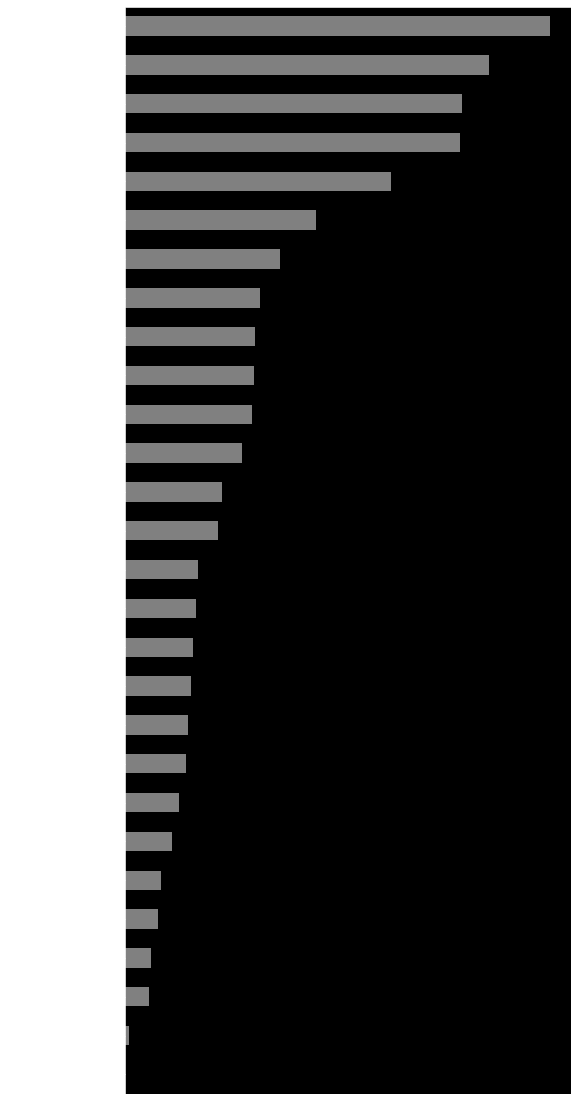

In [79]:
# Examining feature importances
model = thelorax2.named_steps['randomforestclassifier']
encoder = thelorax2.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey', figsize = [8,20])

In [80]:
topten = importances.sort_values(ascending = False).index.tolist()[:22]

In [81]:
X_train_best = X_train[topten]
X_val_best = X_val[topten]

In [82]:
# Checking accuracy

thelorax2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=2049,max_depth=27, min_samples_leaf=2, 
                           random_state=42, n_jobs = -1)
)

thelorax2.fit(X_train,y_train)
print ('train accuracy: ', thelorax2.score(X_train, y_train))
print ('validation accuracy: ', thelorax2.score(X_val, y_val))

train accuracy:  0.9284511784511784
validation accuracy:  0.8112794612794613


In [83]:
# Predicting test data

y_test_pred = thelorax2.predict(X_test)

In [84]:
# Formatting submission
submission = sample_submission.copy()
submission['status_group'] = y_test_pred
submission.to_csv('submission-04.csv', index = False)